In [45]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.ensemble import RandomForestRegressor

In [18]:
train = pd.read_pickle('../data/train_02032024.pkl')
test = pd.read_pickle('../data/test_02032024.pkl')

In [25]:
train['group_model_year_level'] = train['brand'] + '_' + train['model'] + '_' + train['registration_year'].astype(int).astype(str)
train['group_model_level'] = train['brand'] + '_' + train['model']
train['group_year_level'] = train['brand'] + '_' + train['registration_year'].astype(int).astype(str)

In [26]:
test['group_model_year_level'] = test['brand'] + '_' + test['model'] + '_' + test['registration_year'].astype(int).astype(str)
test['group_model_level'] = test['brand'] + '_' + test['model']
test['group_year_level'] = test['brand'] + '_' + test['registration_year'].astype(int).astype(str)

In [27]:
train_validation, test_validation = train_test_split(train, test_size=0.15, random_state=42)

In [28]:
cols_to_drop1 = [x for x in train.columns if 'extra' in x]
cols_to_drop2 = [
    'lat',
    'lon',
    'uuid',
    'label',
    'model_stub',
    'thumbs',
    'price_debatable',
    'user_id',
    'title',
    'without_vat',
    'seller',
    'created',
    'seo_json_ld',
     'address_long',
    'modified',
    'battery_range',
    'variant']


In [29]:
train_val_subset = train_validation.drop(columns=cols_to_drop1 + cols_to_drop2).copy()
test_val_subset = test_validation.drop(columns=cols_to_drop1 + cols_to_drop2).copy()
test_subset = test.drop(columns=cols_to_drop1 + cols_to_drop2).copy()

In [30]:
train_val_subset.head()


is_new        id                                  descriptive_title  \
35080   False  42994486  Bmw X4 '19 XDRIVE20D M SPORTPACKET - 6/2019 - ...   
62801   False  44186679  Toyota Yaris '01 - 1/2001 - 249.000 χλμ - Βενζ...   
359     False  10407508  Mercedes-Benz Sprinter '08 ΨΥΓΕΙΟ 315 CDI -  -...   
15185   False  41911942  Peugeot 208 '16 NAVIGATION-CRUISE CONTROL-LED....   
45364   False  43565109  Opel Agila '09 1.2 NJOY - 11/2009 - 135.000 χλ...   

        mileage  crashed  raw_price  engine_size  registration_month  \
35080  140000.0    False    58000.0       2000.0                   6   
62801  249000.0    False     3500.0       1300.0                   1   
359         0.0    False    16000.0       2200.0                   1   
15185  110329.0    False     9950.0       1600.0                   4   
45364  135000.0    False     6800.0       1242.0                  11   

       registration_year  engine_power  ... is_metallic comfort_options  \
35080               2019         231.0  ...        True        0.888889   
62801               2001          85.0  ...       False        0.111111   
359                 2008         150.0  ...       False        0.444444   
15185               2016         100.0  ...        True        0.555556   
45364               2009          86.0  ...        True        0.444444   

      safety_driver_assistance_options performance_handling_options  \
35080                         0.842105                          0.8   
62801                         0.000000                          0.0   
359                           0.105263                          0.0   
15185                         0.578947                          0.4   
45364                         0.473684                          0.2   

      utility_options premium_options infotainment_options  \
35080        0.666667             0.6             0.818182   
62801        0.000000             0.0             0.090909   
359          0.000000             0.0             0.000000   
15185        0.000000             0.1             0.363636   
45364        0.666667             0.0             0.090909   

            group_model_year_level       group_model_level    group_year_level  
35080                  bmw_x4_2019                  bmw_x4            bmw_2019  
62801            toyota_yaris_2001            toyota_yaris         toyota_2001  
359    mercedes-benz_sprinter_2008  mercedes-benz_sprinter  mercedes-benz_2008  
15185             peugeot_208_2016             peugeot_208        peugeot_2016  
45364              opel_agila_2009              opel_agila           opel_2009  

[5 rows x 49 columns]

# Base model

In [36]:
count_model_year_level = train.groupby('group_model_year_level')['group_model_year_level'].count()
count_model_level = train.groupby('group_model_level')['group_model_level'].count()
count_year_level = train.groupby('group_year_level')['group_year_level'].count()
count_brand_level = train.groupby('brand')['brand'].count()

In [41]:
'bmw_x4_201' in count_model_year_level

False

In [105]:
def predict(row, train_set,thresh):
    model_year = row['group_model_year_level']
    model_level = row['group_model_level']
    year_level = row['group_year_level']
    if (model_year in count_model_year_level) and count_model_year_level[model_year] >= thresh:
        return train_set.loc[train_set['group_model_year_level'] == model_year,'raw_price'].median(), 'group_model_year_level'
    elif (model_level in count_model_level) and count_model_level[model_level] >= thresh:
        return train_set.loc[train_set['group_model_level'] == model_level,'raw_price'].median(), 'group_model_level'
    elif (year_level in count_year_level) and count_year_level[year_level] >= thresh:
        return train_set.loc[train_set['group_year_level'] == year_level,'raw_price'].median(), 'group_year_level'
    else:
        return train_set.loc[train_set['brand'] == row.brand,'raw_price'].median(), 'brand_level'


In [107]:
test[['base_model_pred','used_level']] = test.apply(lambda row: pd.Series(predict(row, train, 5)), axis=1)

In [108]:
test['residuals'] = test['raw_price'] - test['base_model_pred']
test['abs_residuals'] = abs(test['raw_price'] - test['base_model_pred'])
test['ape'] = abs(test['raw_price'] - test['base_model_pred'])/test['raw_price']
print(f"RMSE: {root_mean_squared_error(test['raw_price'], test['base_model_pred'])}")
print(f"MSE: {mean_squared_error(test['raw_price'], test['base_model_pred'])}")
print(f"MAE: {mean_absolute_error(test['raw_price'], test['base_model_pred'])}")
print(f"MAPE: {mean_absolute_percentage_error(test['raw_price'], test['base_model_pred'])}")

RMSE: 8830.404511868599
MSE: 77976043.84322932
MAE: 3238.8453366853987
MAPE: 0.24796687627529276


In [109]:
test_subset['base_model_pred'] = test['base_model_pred']
test_subset['used_level'] = test['used_level']

test_subset['residuals'] = test_subset['raw_price'] - test_subset['base_model_pred']
test_subset['abs_residuals'] = abs(test_subset['raw_price'] - test_subset['base_model_pred'])
test_subset['ape'] = abs(test_subset['raw_price'] - test_subset['base_model_pred'])/test_subset['raw_price']
print(f"RMSE: {root_mean_squared_error(test_subset['raw_price'], test_subset['base_model_pred'])}")
print(f"MSE: {mean_squared_error(test_subset['raw_price'], test_subset['base_model_pred'])}")
print(f"MAE: {mean_absolute_error(test_subset['raw_price'], test_subset['base_model_pred'])}")
print(f"MAPE: {mean_absolute_percentage_error(test_subset['raw_price'], test_subset['base_model_pred'])}")

RMSE: 8830.404511868599
MSE: 77976043.84322932
MAE: 3238.8453366853987
MAPE: 0.24796687627529276


So our basic model gives us an mean absolute percentage error of 28% and an MAE of 3746. Let's analyze the errors

(-30000.0, 30000.0)

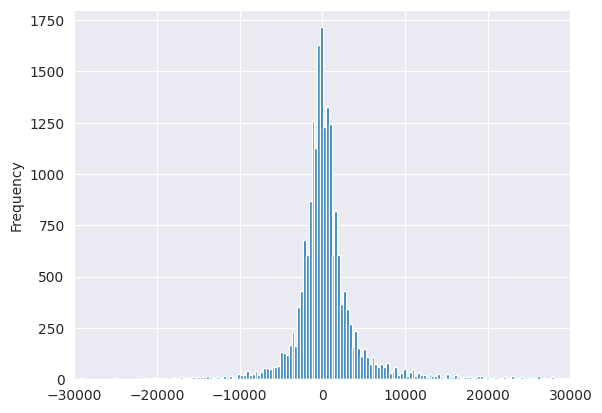

In [110]:
test.residuals.plot(kind='hist',bins=1000)
plt.xlim([-30000, 30000])

In [111]:
pd.concat([test.abs_residuals.describe([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99]),test.ape.describe([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])],axis=1)

abs_residuals           ape
count   20286.000000  20286.000000
mean     3238.845337      0.247967
std      8215.184211      0.669646
min         0.000000      0.000000
1%          0.000000      0.000000
5%        100.000000      0.007866
10%       200.000000      0.020819
25%       555.000000      0.055907
50%      1400.000000      0.128205
75%      2949.500000      0.253341
90%      6507.500000      0.468952
95%     11387.500000      0.707006
99%     32221.100000      2.333333
max    247999.000000     51.030075

In [112]:
pd.concat([test_subset[test_subset.ape> test_subset.ape.quantile(0.97)].mileage.describe(),test_subset.mileage.describe()],axis=1)

mileage       mileage
count  6.090000e+02  2.028600e+04
mean   2.011278e+05  1.345912e+05
std    1.586607e+05  8.608825e+04
min    0.000000e+00  0.000000e+00
25%    1.090000e+05  7.900000e+04
50%    1.900000e+05  1.267270e+05
75%    2.600000e+05  1.800000e+05
max    1.400000e+06  1.400000e+06

In [113]:
pd.concat([test_subset[test_subset.ape> test_subset.ape.quantile(0.97)].raw_price.describe(),test_subset.raw_price.describe()],axis=1)

raw_price      raw_price
count    609.000000   20286.000000
mean    4334.211823   15787.325840
std     5474.305578   17694.852723
min      600.000000     600.000000
25%     1500.000000    7200.000000
50%     2700.000000   11490.000000
75%     4999.000000   17950.000000
max    55000.000000  345000.000000

In [114]:
pd.concat([test_subset[test_subset.ape> test_subset.ape.quantile(0.97)].raw_price.describe(),test_subset.raw_price.describe()],axis=1)

raw_price      raw_price
count    609.000000   20286.000000
mean    4334.211823   15787.325840
std     5474.305578   17694.852723
min      600.000000     600.000000
25%     1500.000000    7200.000000
50%     2700.000000   11490.000000
75%     4999.000000   17950.000000
max    55000.000000  345000.000000

In [150]:
test[test.ape>test.ape.quantile(0.97)].sort_values(by=['ape'],ascending=False)

lat        lon                                  uuid  is_new  \
3351   38.080682  23.814336  f1f8c60c-1837-49c7-993c-e97e41152f53    True   
1385   38.092141  23.611706  44bae6a8-7501-4663-baf9-fd647fd18217   False   
3056   38.073510  23.963336  9fbe55ba-dcfe-4071-81e3-df1593c65c0c   False   
61041  37.840635  21.401010  2f0d6c97-23af-4e0b-95c4-b9100b65a9f4   False   
36090  40.443438  22.449377  89ba914b-5da9-4dcc-952f-55b8ddbad7ed   False   
...          ...        ...                                   ...     ...   
79862  37.862753  23.848026  85c7065f-c5c4-4d04-8658-903279b6c265   False   
87462  37.999395  23.361619  f13a827b-d22b-4d17-a865-aaca8b39bb7f   False   
65611  37.948485  23.674585  3e9da47c-614a-4288-b4aa-6e9af273aca6   False   
8943   41.001058  24.498352  a3eb7570-a506-48db-a8f2-79b7193475b7   False   
75562  38.057705  23.838385  7118d1fc-1797-4822-821f-4899709c241a   False   

      label                                         model_stub  \
3351    new  Peugeot 3008 '24 1.2 136hp Hybrid Allure LEASI...   
1385    NaN   Mercedes-Benz Vito '15 LUXURY ΑΜΕΑ ΜΕ ΑΝΑΒΑΤΟΡΙΟ   
3056    NaN                                    Volvo XC 90 '03   
61041   NaN                            Mercedes-Benz E 250 '01   
36090   NaN                               Citroen Berlingo '01   
...     ...                                                ...   
79862   NaN                  Ford Transit Connect '11 T230 A/C   
87462   NaN            Volkswagen Golf '02 1.6i 105HP ΕΛΛΗΝΙΚΟ   
65611   NaN        Mercedes-Benz CLA 180 '19 Urban style 7-DCT   
8943    NaN                                        Mazda 6 '04   
75562   NaN  Volvo XC 60 '15 2,0 DIESEL AUTOMATIC FACELIFT ...   

                                                  thumbs         id  \
3351   {'count': 3, 'urls': ['https://static.car.gr/4...   41403626   
1385   {'count': 16, 'urls': ['https://static.car.gr/...   30146936   
3056   {'count': 8, 'urls': ['https://static.car.gr/4...   41387804   
61041  {'count': 5, 'urls': ['https://static.car.gr/4...   44158494   
36090  {'count': 4, 'urls': ['https://static.car.gr/4...   43033924   
...                                                  ...        ...   
79862  {'count': 20, 'urls': ['https://static.car.gr/...  333596145   
87462  {'count': 39, 'urls': ['https://static.car.gr/...  339487778   
65611  {'count': 6, 'urls': ['https://static.car.gr/4...   44253784   
8943   {'count': 16, 'urls': ['https://static.car.gr/...   41624452   
75562  {'count': 34, 'urls': ['https://static.car.gr/...  324743678   

       price_debatable     user_id  ... premium_options  infotainment_options  \
3351              True     1010612  ...             0.0              0.181818   
1385              True     1000061  ...             0.1              0.363636   
3056              True  1001109359  ...             0.2              0.181818   
61041             True  1001489042  ...             0.3              0.090909   
36090            False  1001349372  ...             NaN                   NaN   
...                ...         ...  ...             ...                   ...   
79862             True  1000138155  ...             0.0              0.181818   
87462             True     1001453  ...             0.0              0.090909   
65611             True    10066445  ...             0.2              0.636364   
8943             False  1001061282  ...             0.2              0.181818   
75562            False     1005950  ...             0.2              0.545455   

           group_model_year_level      group_model_level    group_year_level  \
3351            peugeot_3008_2024           peugeot_3008        peugeot_2024   
1385      mercedes-benz_vito_2015     mercedes-benz_vito  mercedes-benz_2015   
3056             volvo_xc 90_2003            volvo_xc 90          volvo_2003   
61041    mercedes-benz_e 250_2001    mercedes-benz_e 250  mercedes-benz_2001   
36090       citroen_berlingo_2001       citroen_berlingo        citro

In [115]:
#If we take a look at the ds4 car the predicted price is 28 000 euros whereas its sale price was 16 000 euros. Here we see that the problem of this basemodel is that it does not take into accounts relationships betweem the price and other critically important factors such as the mileage. In fact in predicting the median price over the ds ds4s we predicted for the median mileage of the cars sold on the website.

<Axes: xlabel='mileage', ylabel='raw_price'>

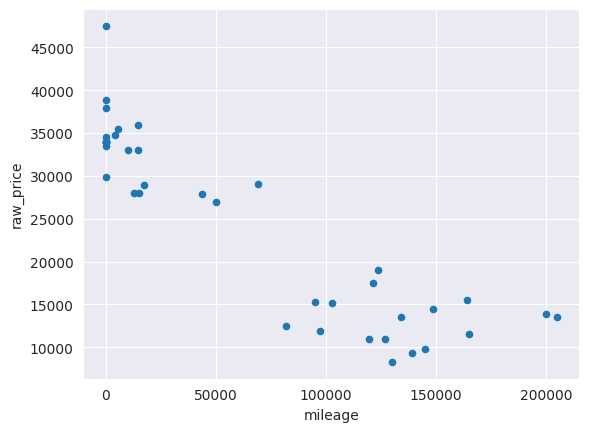

In [116]:
train.loc[train.group_model_level=='ds_ds4',['mileage','raw_price']].plot(kind='scatter', x='mileage', y='raw_price')

In [117]:
# Here we see that we make large errors for low prices

(0.0, 50000.0)

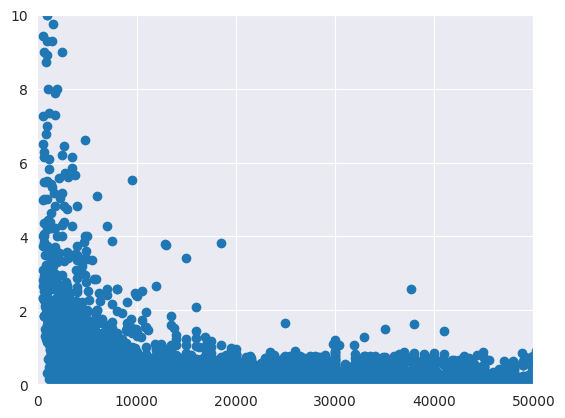

In [118]:
plt.scatter(test.raw_price, test.ape)
plt.ylim([0,10])
plt.xlim([0,50000])

In [119]:
#Here we see that we make errors on cars with very low mileage or high mileage (200 000)

(0.0, 1000000.0)

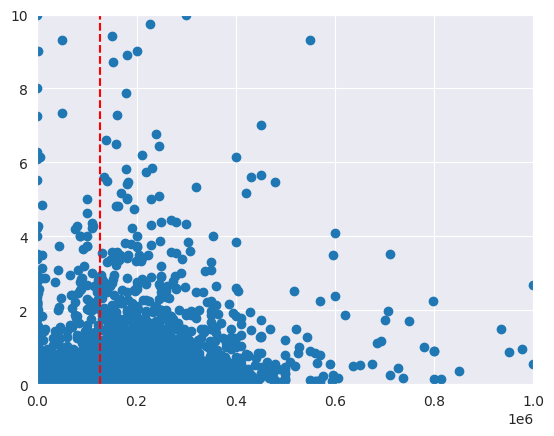

In [120]:
plt.scatter((test.mileage), test.ape)
plt.axvline(test.mileage.median(), color='red', linestyle='--')
plt.ylim([0,10])
plt.xlim([0,1000000])

In [121]:
# Here we see that we make errors on older cars

(0.0, 10.0)

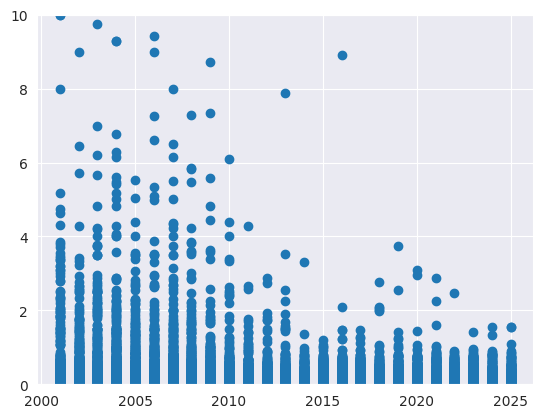

In [122]:
plt.scatter((test.registration_year), test.ape)
plt.ylim([0,10])

(0.0, 5.0)

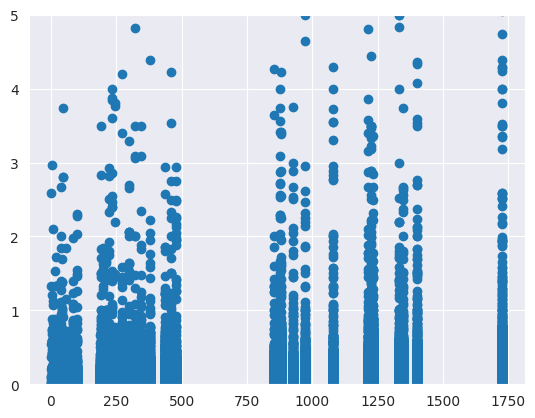

In [123]:
plt.scatter(test.groupby('brand')['brand'].transform('count'), test.ape)
plt.ylim([0,5])

(0.0, 2.0)

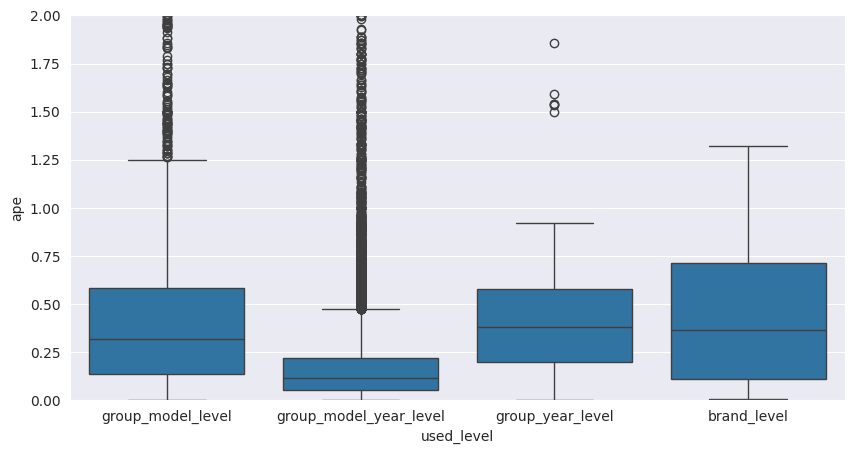

In [127]:
plt.figure(figsize=(10,5))
sns.boxplot(data=test,x='used_level',y='ape')
plt.ylim([0,2])


In [134]:
zoom = test.groupby('used_level')['ape'].apply(lambda x: x.describe())

In [147]:
zoom.unstack(0)

used_level  brand_level  group_model_level  group_model_year_level  \
count         53.000000        2204.000000            17800.000000   
mean           0.579231           0.600590                0.201120   
std            0.739856           1.178155                0.564116   
min            0.010000           0.000000                0.000000   
25%            0.109756           0.134775                0.051724   
50%            0.363636           0.319232                0.116259   
75%            0.716361           0.586322                0.220947   
max            2.960000          16.560000               51.030075   

used_level  group_year_level  
count             229.000000  
mean                0.418870  
std                 0.297863  
min                 0.000000  
25%                 0.199833  
50%                 0.379845  
75%                 0.577143  
max                 1.857143

(0.0, 20.0)

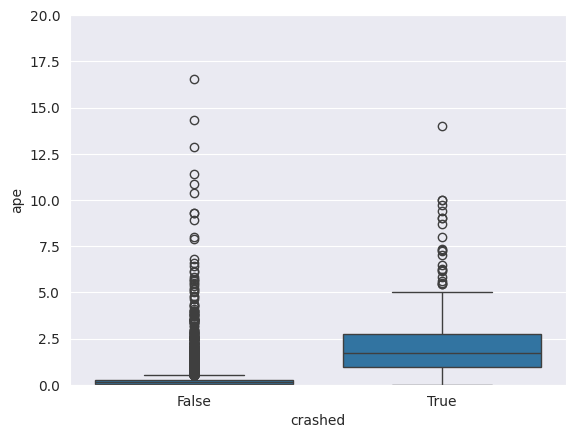

In [153]:
sns.boxplot(data=test,x='crashed',y='ape')
plt.ylim([0,20])

In [155]:
test.groupby('crashed')['ape'].apply(lambda x: x.describe([0.1])).unstack(0)

crashed         False       True 
count    19985.000000  301.000000
mean         0.218467    2.206605
std          0.581416    1.973767
min          0.000000    0.000000
10%          0.020443    0.501926
50%          0.125016    1.727273
max         51.030075   14.000000

In [156]:
test.residuals.describe()

count     20286.000000
mean        946.284556
std        8779.771595
min      -97300.000000
25%       -1200.000000
50%           0.000000
75%        1509.000000
max      247999.000000
Name: residuals, dtype: float64

In [180]:
train.groupby('group_model_year_level')['raw_price'].count()['ds_ds3_2024']

np.int64(5)

In [162]:
test.columns

Index(['lat', 'lon', 'uuid', 'is_new', 'label', 'model_stub', 'thumbs', 'id',
       'price_debatable', 'user_id',
       ...
       'premium_options', 'infotainment_options', 'group_model_year_level',
       'group_model_level', 'group_year_level', 'base_model_pred', 'residuals',
       'abs_residuals', 'ape', 'used_level'],
      dtype='object', length=127)

In [148]:
# Let's try to lower the threshold even more

In [ ]:
# We see that when evaluating the median on both year and level the errors are smaller

In [181]:
#LinearRegression

In [183]:
train_val_subset.columns.values

array(['is_new', 'id', 'descriptive_title', 'mileage', 'crashed',
       'raw_price', 'engine_size', 'registration_month',
       'registration_year', 'engine_power', 'fuel_type', 'gearbox_type',
       'brand', 'model', 'description', 'never_crashed', 'interior_type',
       'seats', 'kteo', 'exterior_color', 'number_plate_ending',
       'emissions_co2', 'battery_charge_time', 'interior_color',
       'rim_size', 'vehicle_height', 'number_of_gears', 'torque',
       'gross_weight', 'acceleration', 'vehicle_width', 'body_type',
       'vehicle_length', 'top_speed', 'trim', 'wheelbase',
       'fuel_consumption', 'drive_type', 'doors', 'is_metallic',
       'comfort_options', 'safety_driver_assistance_options',
       'performance_handling_options', 'utility_options',
       'premium_options', 'infotainment_options',
       'group_model_year_level', 'group_model_level', 'group_year_level'],
      dtype=object)

In [185]:
train.isnull().sum().sort_values(ascending=True)

lat                        0
lon                        0
uuid                       0
is_new                     0
model_stub                 0
                       ...  
kteo                   46373
emissions_co2          62985
battery_range          79403
label                  79737
battery_charge_time    80362
Length: 122, dtype: int64

In [334]:
cols_to_keep = ['is_new', 'mileage', 'crashed',
       'raw_price', 'engine_size',
       'registration_year', 'engine_power', 'fuel_type', 'gearbox_type',
       'brand', 'model',
       'seats',  'exterior_color',  'doors', 'is_metallic',
       'group_model_year_level', 'group_model_level', 'group_year_level']

In [335]:
train_val_linreg =train_val_subset.loc[:, cols_to_keep].copy()
test_val_linreg = test_val_subset.loc[:, cols_to_keep].copy()

In [213]:
ohe_fuel = OneHotEncoder(handle_unknown='ignore', drop='first') #
ohe_gearbox = OneHotEncoder(handle_unknown='ignore', drop='first') #

In [336]:
train_val_linreg['is_new'] = train_val_linreg['is_new'].astype('int')
train_val_linreg['crashed'] = train_val_linreg['crashed'].astype('int')

In [428]:
test_val_linreg['is_new'] = test_val_linreg['is_new'].astype('int')
test_val_linreg['crashed'] = test_val_linreg['crashed'].astype('int')

<Axes: >

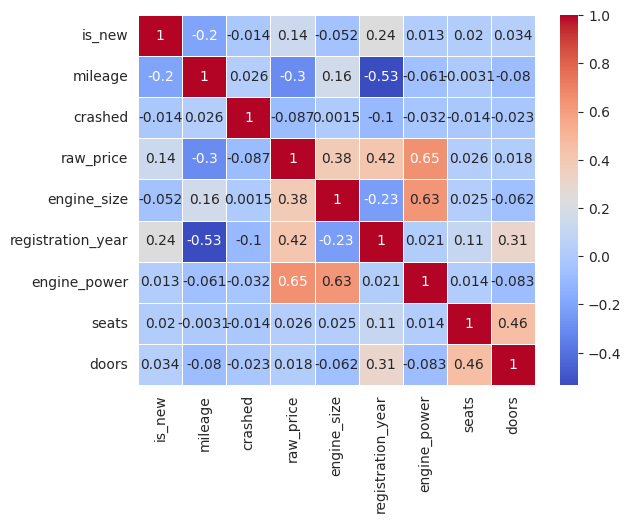

In [233]:
sns.heatmap(train_val_linreg.select_dtypes(include=[np.number]).corr(), annot=True, linewidths=.5, cmap='coolwarm')

<Axes: ylabel='Frequency'>

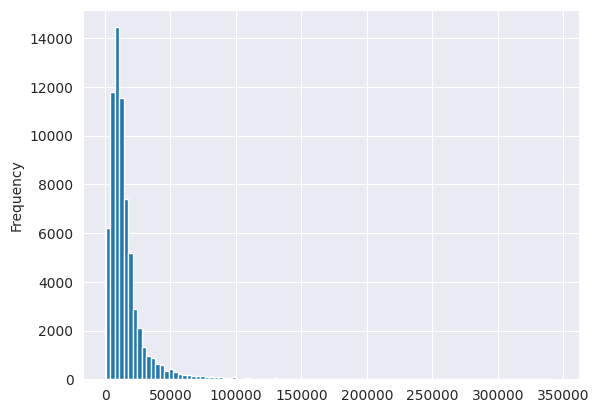

In [236]:
(train_val_linreg.raw_price).plot(kind='hist',bins=100)

<Axes: ylabel='Frequency'>

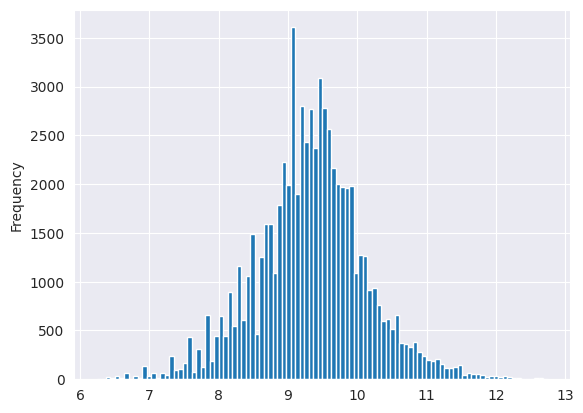

In [235]:
np.log(train_val_linreg.raw_price).plot(kind='hist',bins=100)

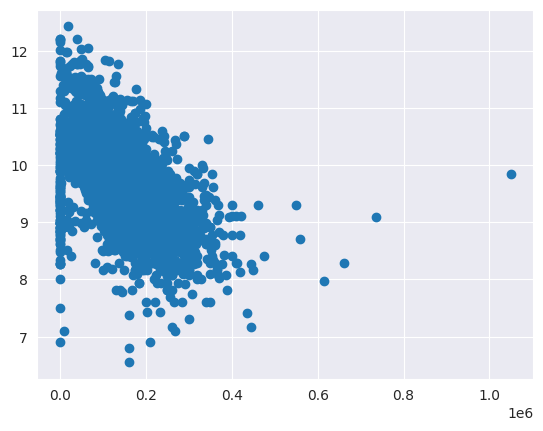

In [239]:
plt.scatter(train_val_linreg[train_val_linreg.brand=='audi'].mileage,(train_val_linreg[train_val_linreg.brand=='audi'].raw_price.apply(np.log)))

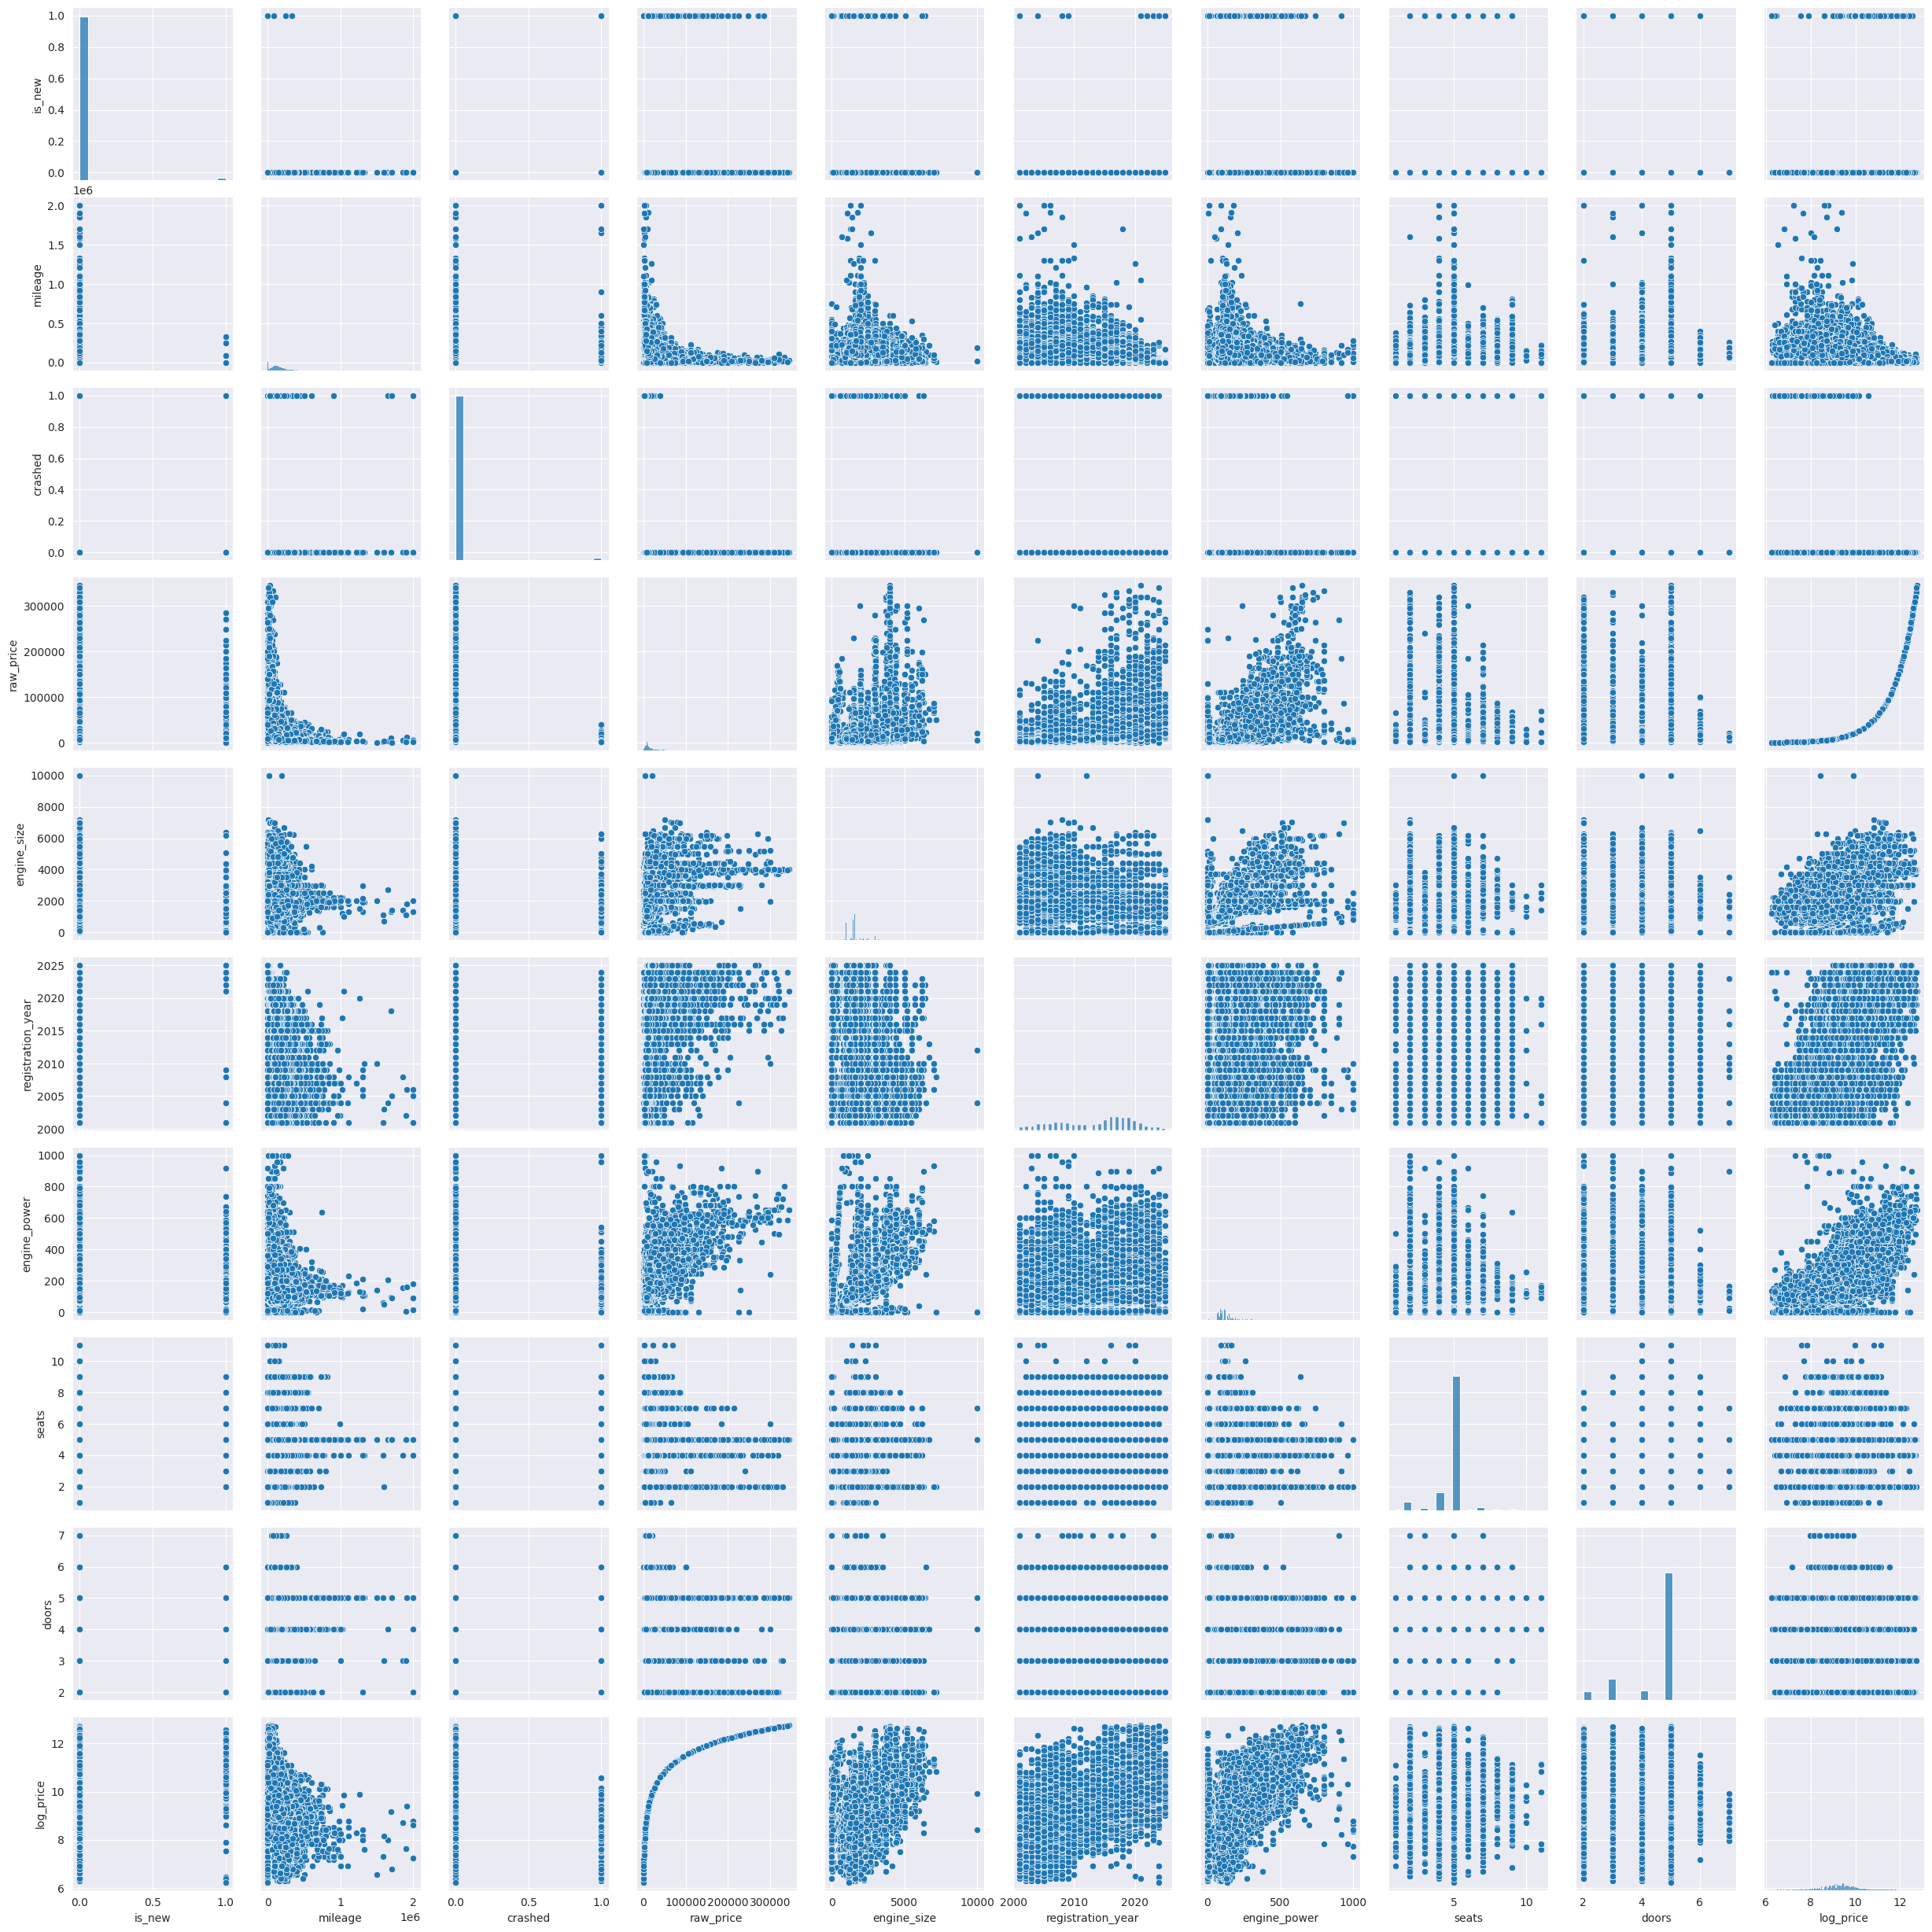

In [242]:
sns.pairplot(train_val_linreg.select_dtypes(include=[np.number]))

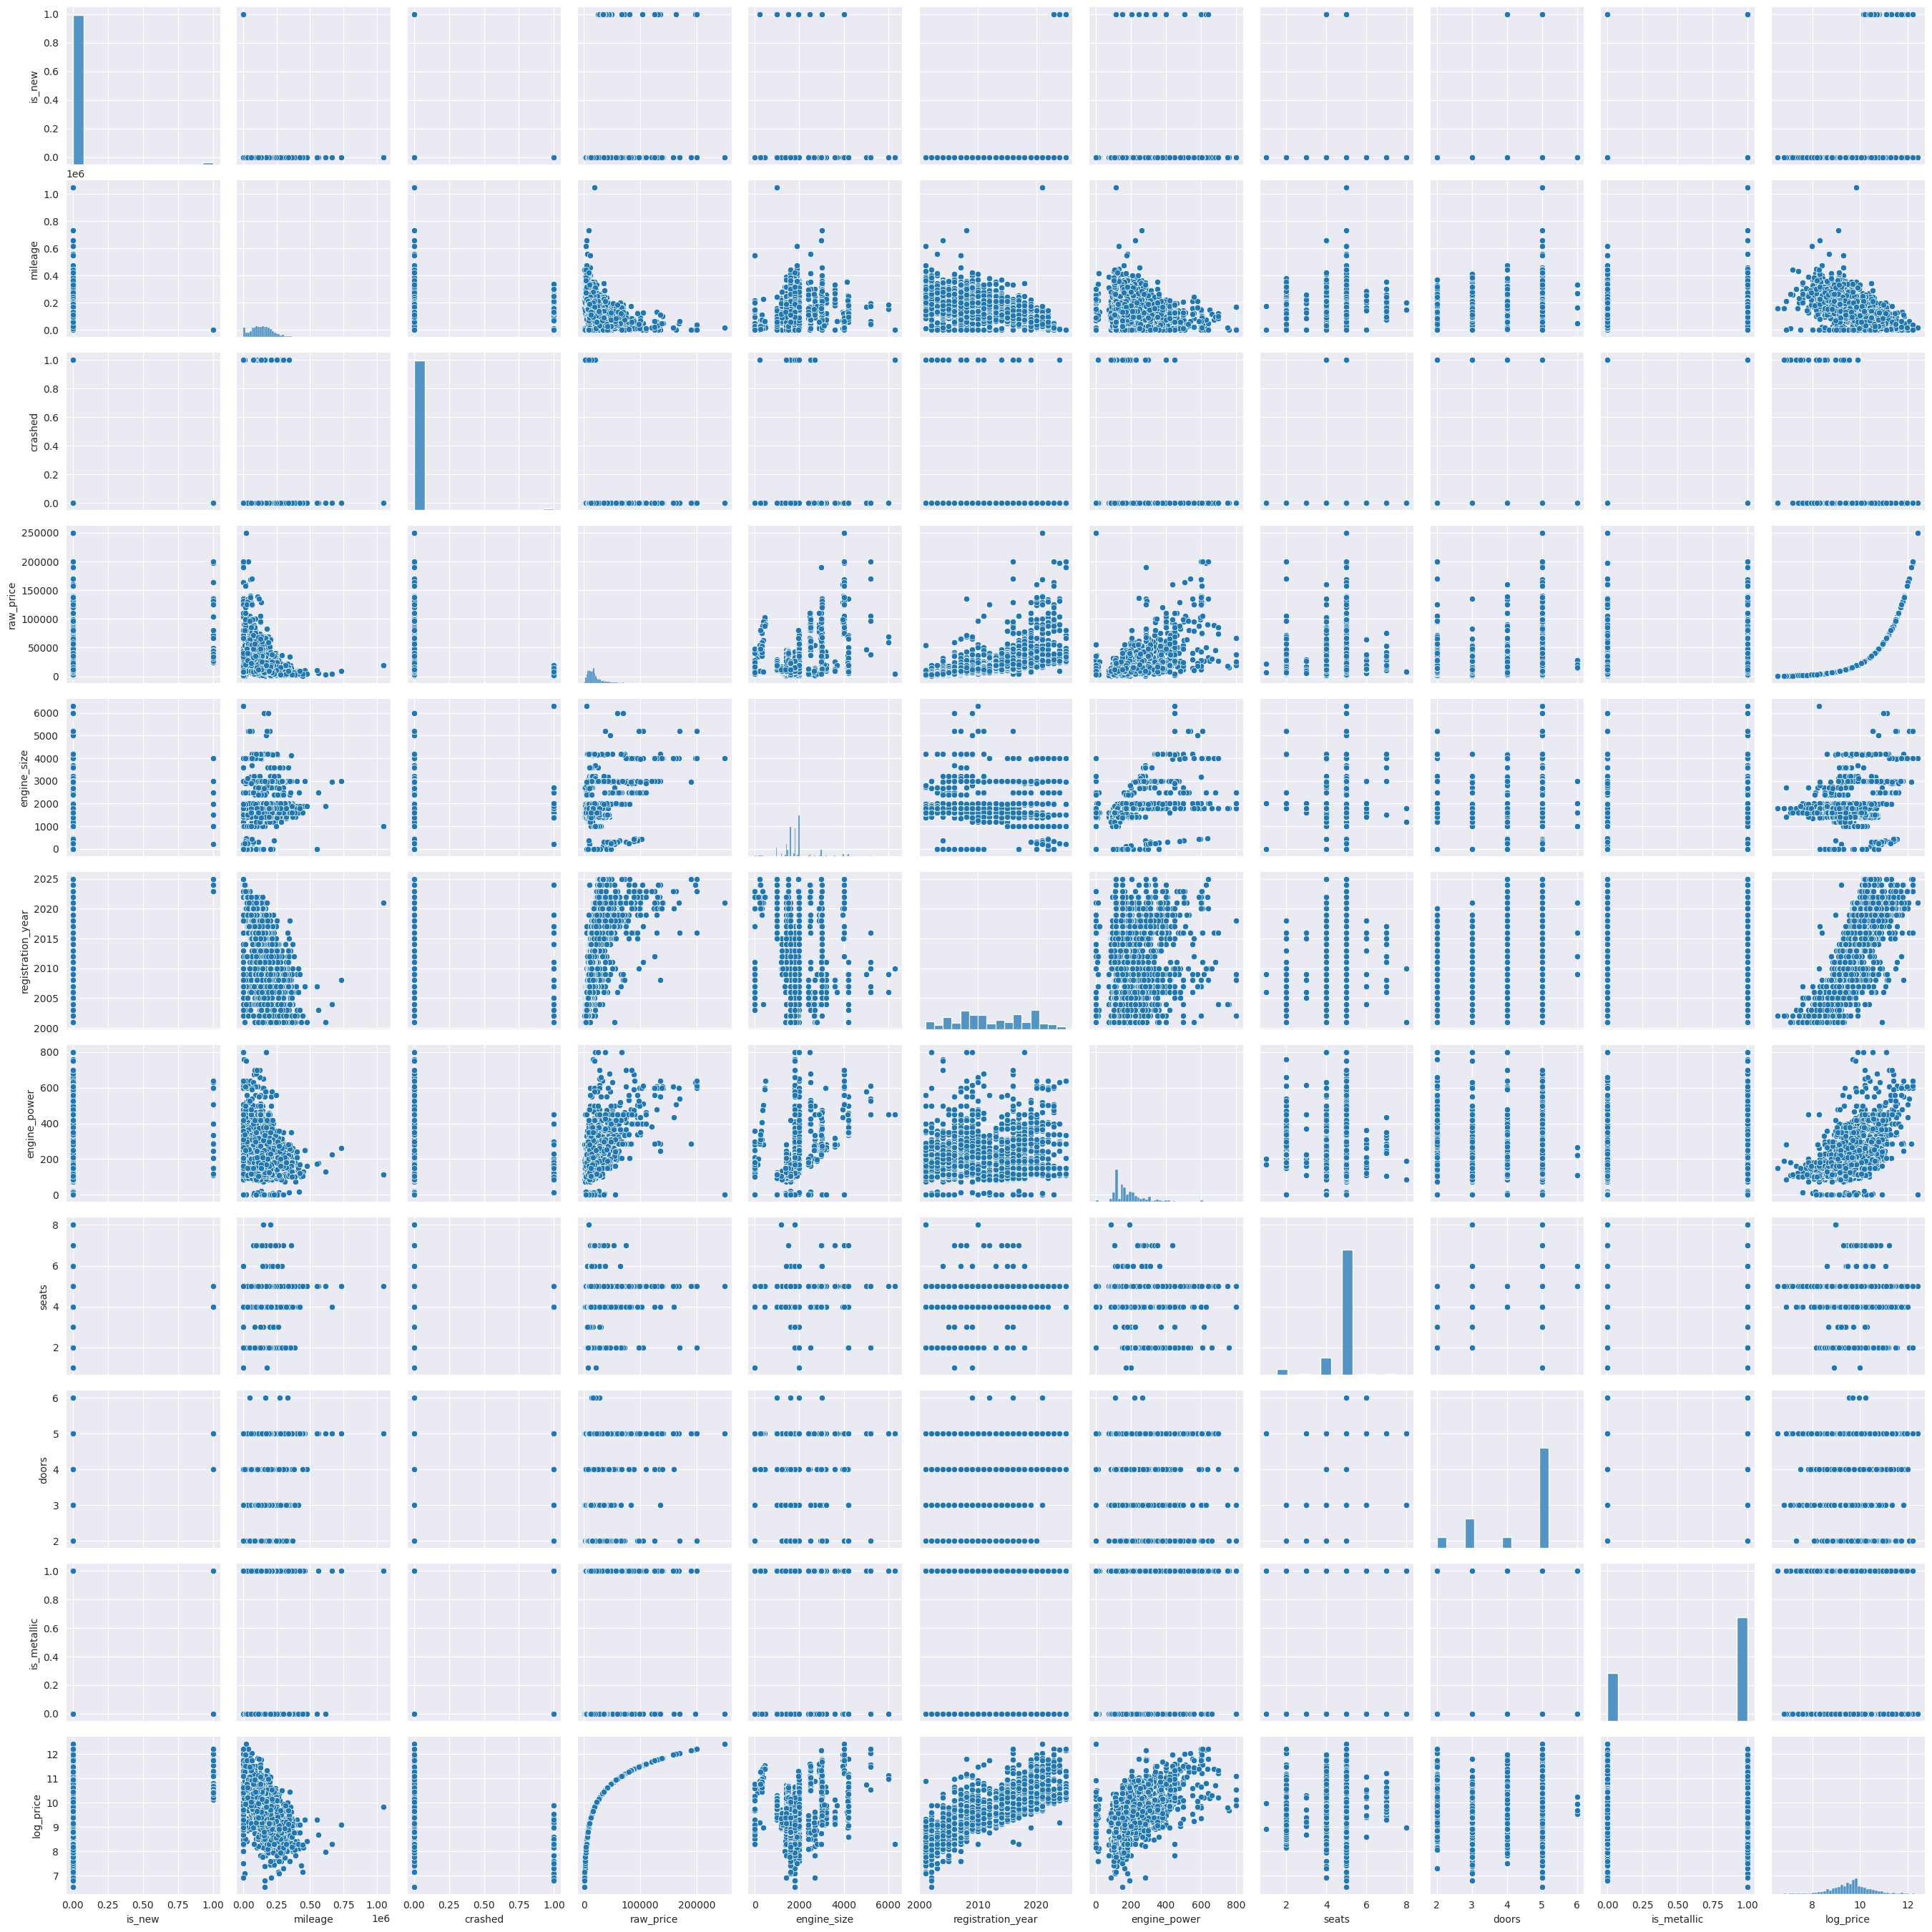

In [243]:
sns.pairplot(train_val_linreg[train_val_linreg.brand=='audi'])

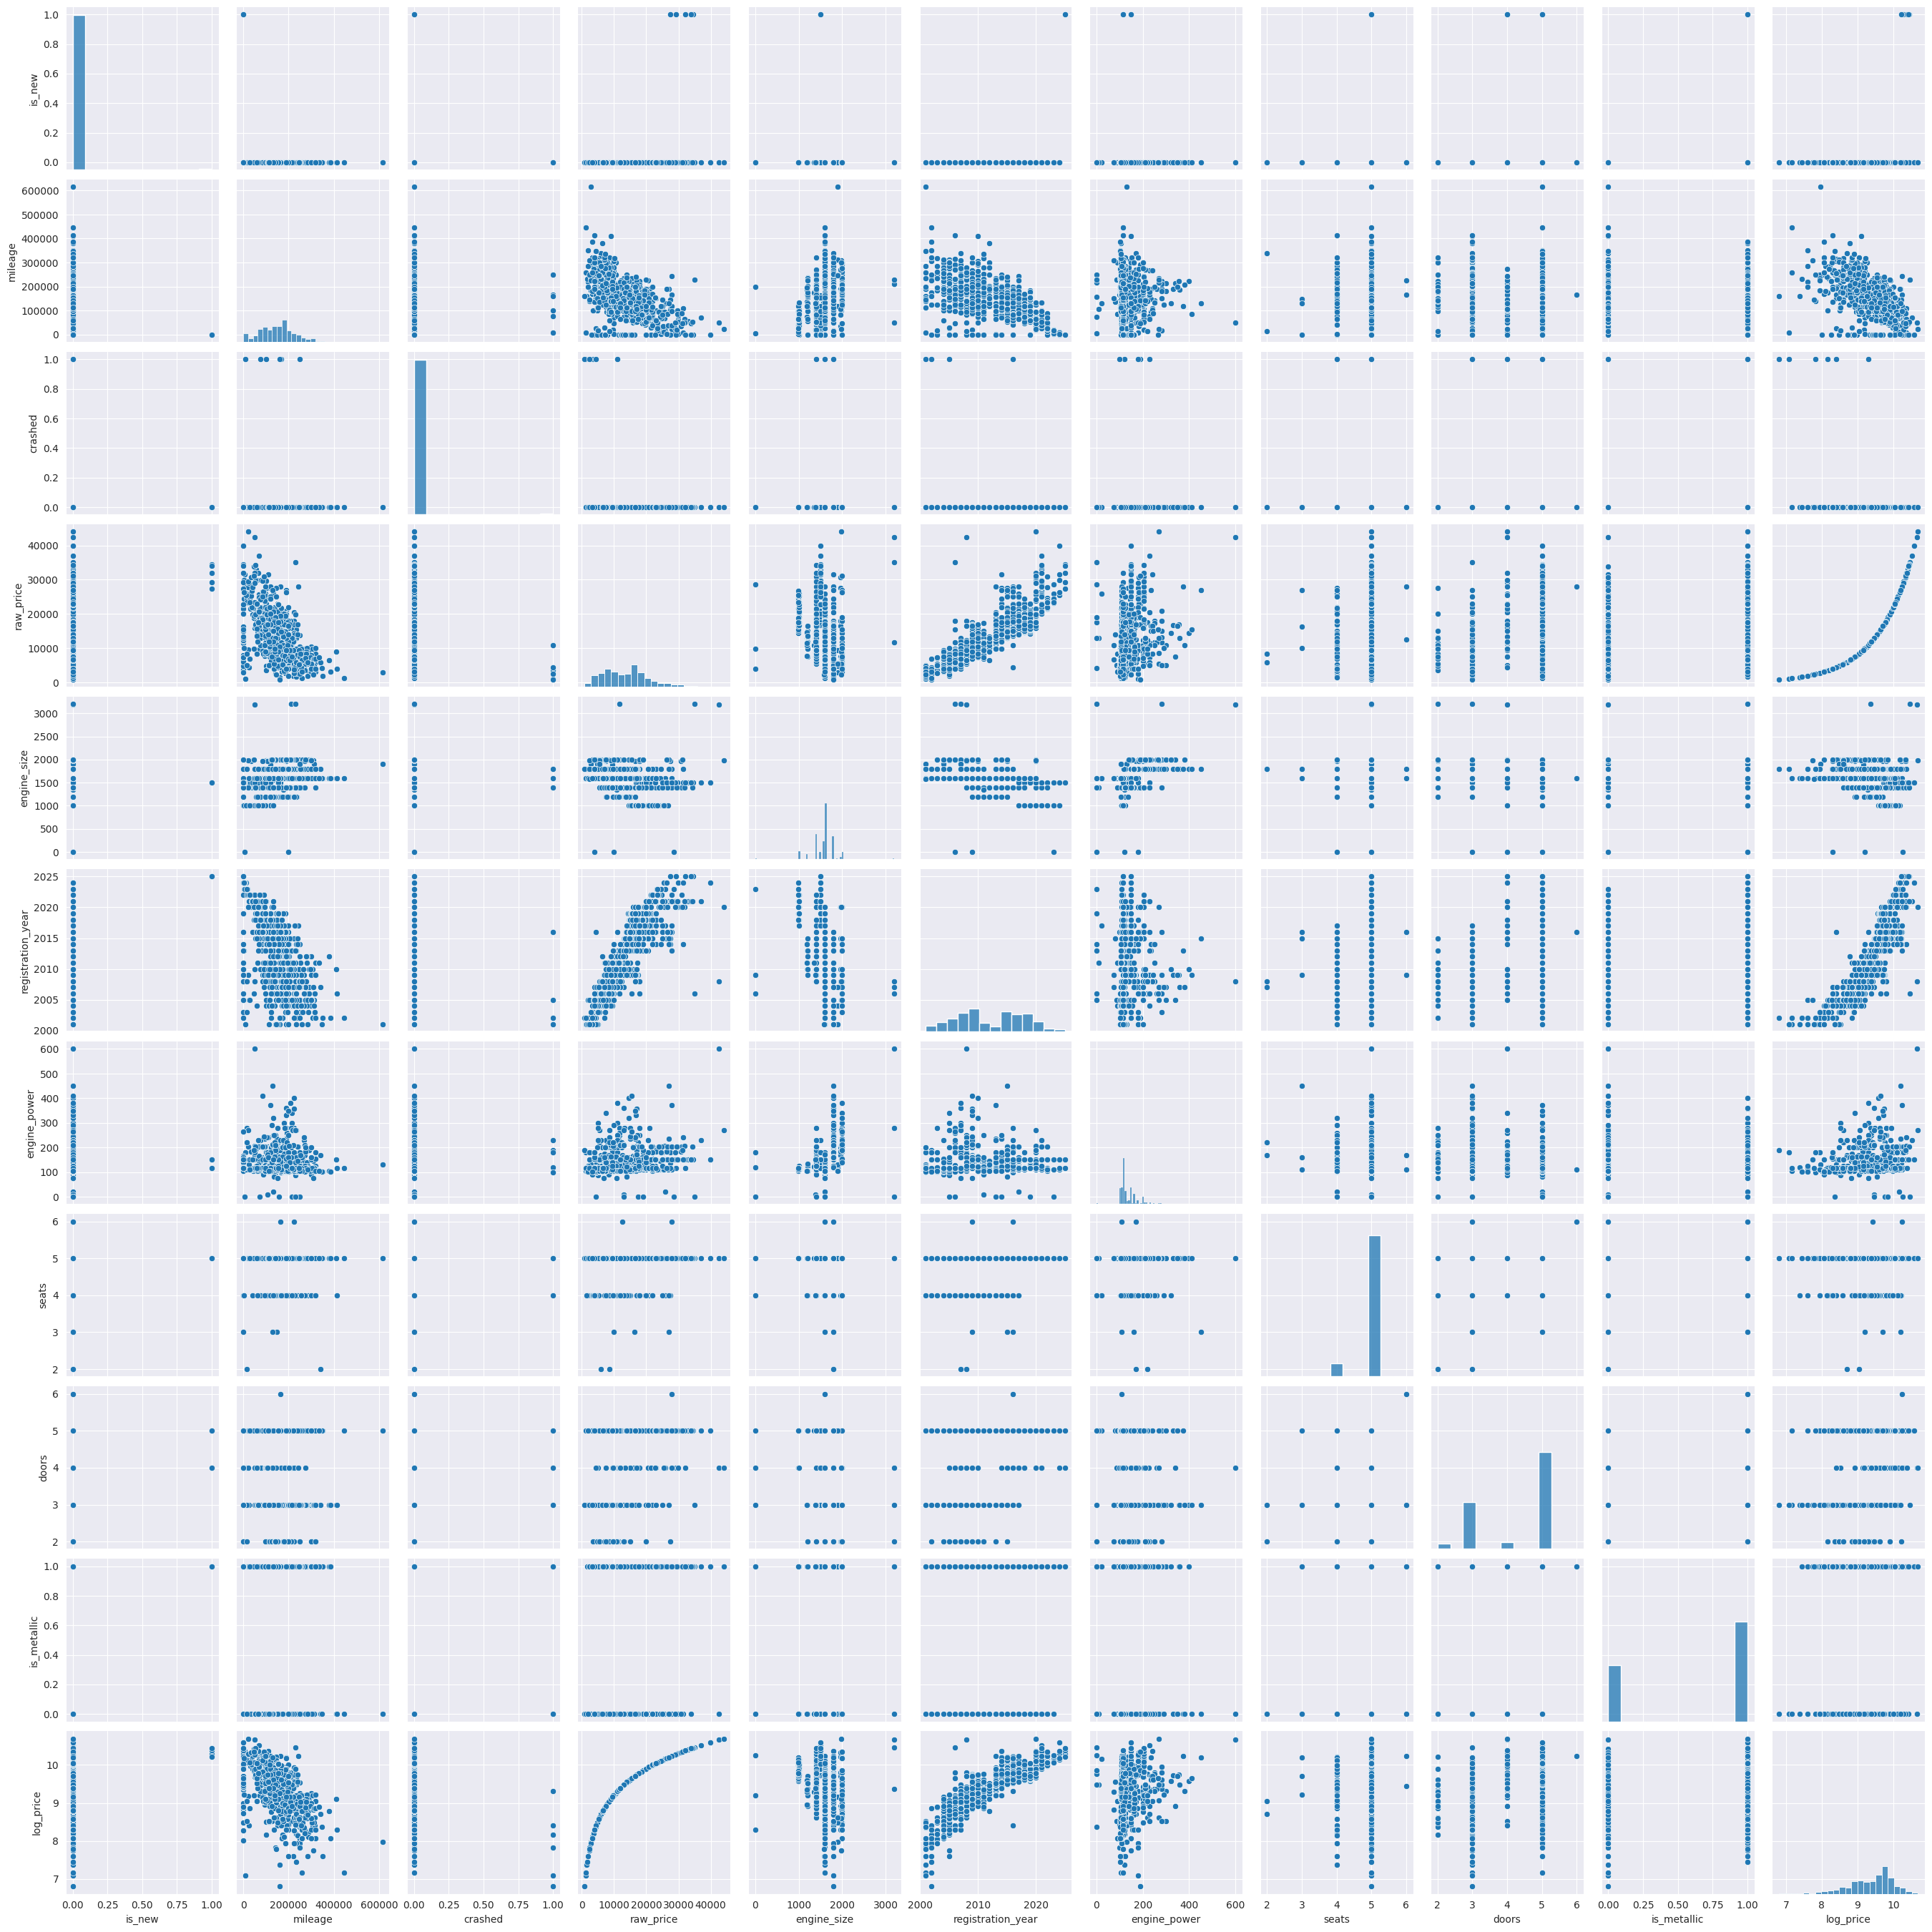

In [244]:
sns.pairplot(train_val_linreg[(train_val_linreg.brand=='audi')&(train_val_linreg.model=='a3')])

In [192]:
# On observe une forte correlation entre engine power et engine size. on ne gardera que l'une des deux pour eviter d'avoir des covariables fortement correelees. De meme pour doors et seats ( on gardera seats sachant que l'annee est fortement correlee avec doors).

In [337]:
from tqdm import tqdm
import statsmodels.api as sm

In [649]:
cols_to_keep = ['mileage', 'engine_size', 'seats','registration_year','crashed','is_new']

In [650]:
train_val_linreg['log_price'] = train_val_linreg['raw_price'].apply(np.log)

In [651]:
test_val_linreg['log_price'] = test_val_linreg['raw_price'].apply(np.log)

In [578]:
train_val_linreg.columns

Index(['is_new', 'mileage', 'crashed', 'raw_price', 'engine_size',
       'registration_year', 'engine_power', 'fuel_type', 'gearbox_type',
       'brand', 'model', 'seats', 'exterior_color', 'doors', 'is_metallic',
       'group_model_year_level', 'group_model_level', 'group_year_level',
       'log_price'],
      dtype='object')

In [350]:
train_val_linreg.drop(columns='const',inplace=True)

In [692]:
dict_linreg_models = {}
dict_linreg_brands = {}
for group in tqdm(train_val_linreg.group_model_level.unique()):
    scaler = StandardScaler()
    X = scaler.fit_transform(((train_val_linreg.loc[train_val_linreg.group_model_level == group,cols_to_keep])))
    X = sm.add_constant(X)
    linreg = sm.OLS(train_val_linreg.loc[train_val_linreg.group_model_level == group,'raw_price'],X)
    dict_linreg_models[group] = [linreg.fit(), scaler, train_val_linreg[train_val_linreg.group_model_level == group].shape[0]]

for group in tqdm(train_val_linreg.brand.unique()):
    scaler = StandardScaler()
    X = scaler.fit_transform((train_val_linreg.loc[train_val_linreg.brand == group,cols_to_keep]))
    X = sm.add_constant(X)
    linreg = sm.OLS(train_val_linreg.loc[train_val_linreg.brand == group,'raw_price'],X)
    dict_linreg_brands[group] = [linreg.fit(), scaler,  train_val_linreg[train_val_linreg.brand == group].shape[0]]



100%|██████████| 69/69 [00:00<00:00, 88.61it/s]


In [580]:
zoom = dict_linreg_models['citroen_c3'][2]

In [549]:
import math

In [693]:
def predict_linreg(row, thresh=70):

    if row.group_model_level in dict_linreg_models.keys():
        if dict_linreg_models[row.group_model_level][2] >= thresh:
            model = dict_linreg_models[row.group_model_level][0]
            scaler = dict_linreg_models[row.group_model_level][1]
            row = pd.DataFrame(scaler.transform(row.loc[cols_to_keep].to_frame().T), columns=cols_to_keep)
            row = sm.add_constant(row, has_constant='add')
            pred = model.predict(row)
            return pred
        else:
            model = dict_linreg_brands[row.brand][0]
            scaler = dict_linreg_brands[row.brand][1]
            row = pd.DataFrame(scaler.transform(row[cols_to_keep].to_frame().T), columns=cols_to_keep)
            row = sm.add_constant(row, has_constant='add')
            pred = model.predict(row)
            return pred


    elif row.brand in dict_linreg_brands.keys():
        model = dict_linreg_brands[row.brand][0]
        scaler = dict_linreg_brands[row.brand][1]
        row = pd.DataFrame(scaler.transform(row[cols_to_keep].to_frame().T), columns=cols_to_keep)
        row = sm.add_constant(row, has_constant='add')
        pred = model.predict(row)
        return pred

    else:
        print(f'predicted mean for {row.group_model_level}')
        return train_val_linreg.log_price.median()





In [656]:
maes = []
threshs = [10,20,30,40,50]

for thresh in tqdm(threshs):
    test_val_linreg['log_prediction'] = test_val_linreg.apply(lambda x : predict_linreg(x, thresh=thresh),axis=1)
    test_val_linreg['abs_residual'] = np.abs(np.log(test_val_linreg.raw_price) - test_val_linreg.log_prediction)
    maes.append(test_val_linreg.abs_residual.mean())



100%|██████████| 5/5 [01:49<00:00, 21.98s/it]


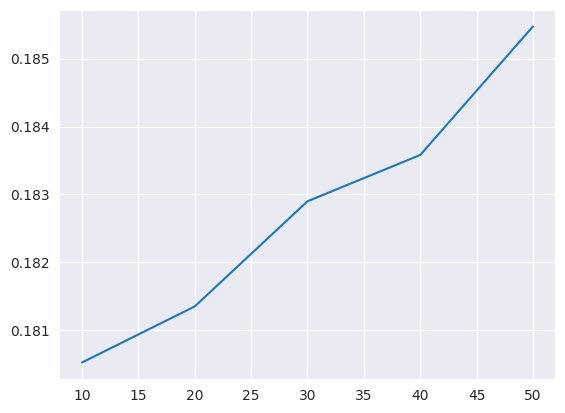

In [657]:
plt.plot(threshs, maes)

In [658]:
test_val_linreg.loc[test_val_linreg.log_prediction.isna()]

Empty DataFrame
Columns: [is_new, mileage, crashed, raw_price, engine_size, registration_year, engine_power, fuel_type, gearbox_type, brand, model, seats, exterior_color, doors, is_metallic, group_model_year_level, group_model_level, group_year_level, log_price, log_prediction, pred, residual, abs_residual, ape]
Index: []

[0 rows x 24 columns]

In [ ]:
test_val_linreg['log_prediction'] = test_val_linreg.apply(lambda x : predict_linreg(x, thresh=20),axis=1)


In [695]:
test_val_linreg['pred'] = (test_val_linreg.log_prediction)
test_val_linreg['residual'] = test_val_linreg.raw_price - test_val_linreg.pred
test_val_linreg['abs_residual'] = np.abs(test_val_linreg.raw_price - test_val_linreg.pred)
test_val_linreg['ape'] = np.abs(test_val_linreg.raw_price - test_val_linreg.pred)/np.abs(test_val_linreg.raw_price)

In [696]:
print(f"MAPE: {test_val_linreg.ape.mean()}")
print(f"MAE: {test_val_linreg.abs_residual.mean()}")

MAPE: 0.24606108234492136
MAE: 3155.1739413995424


In [662]:
test_val_linreg.ape.describe([0.01,0.1,0.9,0.95,0.99])

count    1.217200e+04
mean     2.053318e-01
std      1.864316e+00
min      3.410605e-15
1%       2.148336e-03
10%      2.071738e-02
50%      1.223254e-01
90%      3.789836e-01
95%      5.210039e-01
99%      1.128331e+00
max      1.940904e+02
Name: ape, dtype: float64

In [670]:
test_validation.loc[90613].to_frame().T

lat        lon                                  uuid is_new  \
90613  38.011675  23.865407  4aa6ce8a-c23e-4e1a-a816-6d040d2e9ced  False   

      label                    model_stub  \
90613   NaN  Mercedes-Benz S 600 '06 V 12   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 thumbs  \
90613  {'count': 27, 'urls': ['https://static.car.gr/341127684_0_m.jpg', 'https://static.car.gr/341127684_1_m.jpg', 'https://static.car.gr/341127684_2_m.jpg', 'https://static.car.gr/341127684_3_m.jpg', 'https://static.car.gr/341127684_4_m.jpg', 'https://static.car.gr/341127684_5_m.jpg', 'https://static.car.gr/341127684_6_m.jpg', 'https://static.car.gr/341127684_7_m.jpg', 'https://static.car.gr/341127684_8_m.jpg', 'https://static.car.gr/341127684_9_m.jpg', 'https://static.car.gr/341127684_a_m.jpg', 'https://static.car.gr/341127684_b_m.jpg', 'https://static.car.gr/341127684_c_m.jpg', 'https://static.car.gr/341127684_d_m.jpg', 'https://static.car.gr/341127684_e_m.jpg', 'https://static.car.gr/341127684_f_m.jpg', 'https://static.car.gr/341127684_g_m.jpg', 'https://static.car.gr/341127684_h_m.jpg', 'https://static.car.gr/341127684_i_m.jpg', 'https://static.car.gr/341127684_j_m.jpg', 'https://static.car.gr/341127684_k_m.jpg', 'https://static.car.gr/341127684_l_m.jpg', 'https://static.car.gr/341127684_m_m.jpg', 'https://static.car.gr/341127684_n_m.jpg', 'https://static.car.gr/341127684_o_m.jpg', 'https://static.car.gr/341127684_p_m.jpg', 'https://static.car.gr/341127684_q_m.jpg']}   

              id price_debatable  user_id  ... is_metallic comfort_options  \
90613  341127684            True  1010540  ...        True        0.555556   

      safety_driver_assistance_options performance_handling_options  \
90613                         0.315789                          0.4   

      utility_options premium_options infotainment_options  \
90613        0.333333             0.3             0.181818   

         group_model_year_level    group_model_level    group_year_level  
90613  mercedes-benz_s 600_2006  mercedes-benz_s 600  mercedes-benz_2006  

[1 rows x 122 columns]

In [671]:
test_val_linreg['model_level_used'] = test_val_linreg.groupby('group_model_level')['group_model_level'].transform('count') >= 20

(0.0, 0.8)

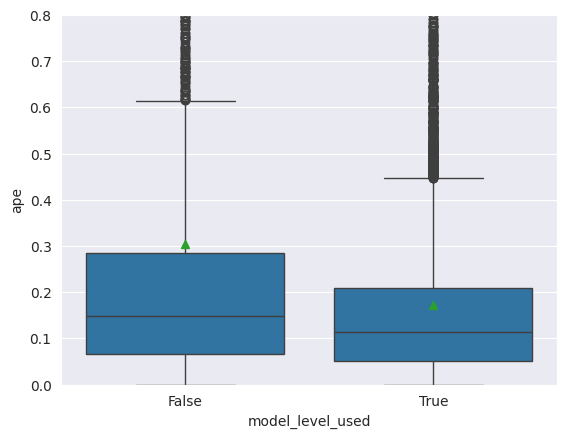

In [680]:
sns.boxplot(data=test_val_linreg, x='model_level_used', y='ape', showmeans=True)
plt.ylim([0,0.8])

In [690]:
test_val_linreg.shape

(12172, 25)

In [689]:
qs = [0.01,0.1,0.9,0.95,0.99]
pd.concat([test_val_linreg.loc[test_val_linreg.model_level_used,'ape'].describe(qs),test_val_linreg.loc[~(test_val_linreg.model_level_used),'ape'].describe(qs)],axis=1)

ape           ape
count  9147.000000  3.025000e+03
mean      0.172345  3.050763e-01
std       0.679417  3.546764e+00
min       0.000011  3.410605e-15
1%        0.001885  2.702271e-03
10%       0.019425  2.560458e-02
50%       0.114331  1.473802e-01
90%       0.345653  4.830858e-01
95%       0.467544  6.781391e-01
99%       0.908617  1.922034e+00
max      61.825681  1.940904e+02

In [691]:
#We observe larger errors when regressions fitted at the brand level is used. This is logical as we observed clearer linear relationships at the model level and also because the model is a critical characteristic for estimating the price of a car.

(0.0, 2.0)

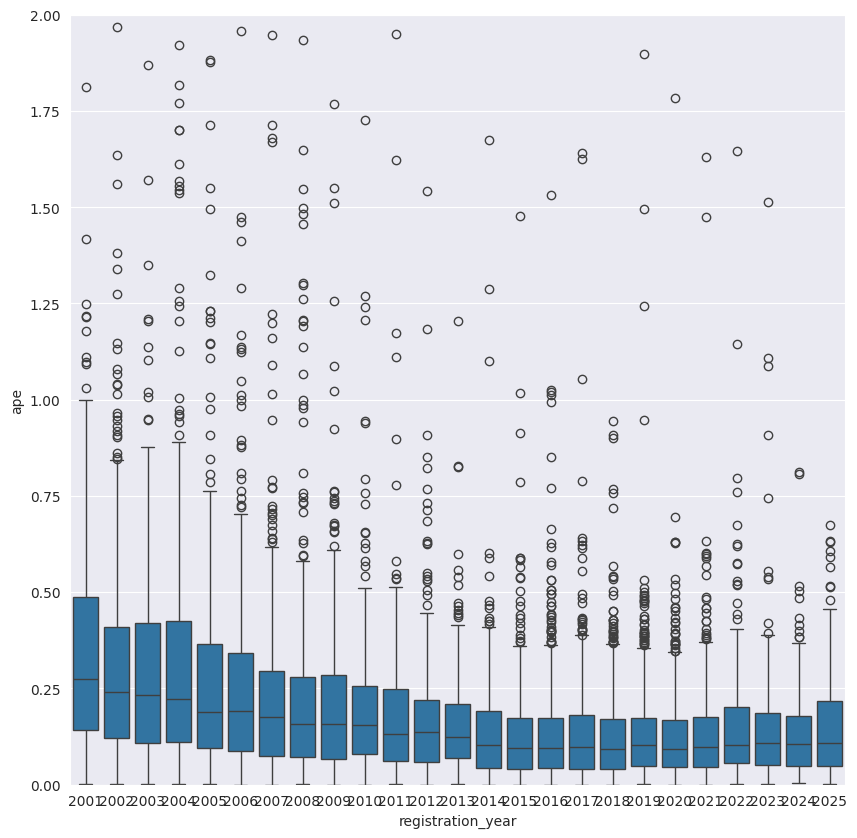

In [646]:
plt.figure(figsize=(10,10))
sns.boxplot(data=test_val_linreg, x='registration_year', y='ape')
plt.ylim([0,2])

(0.0, 20000.0)

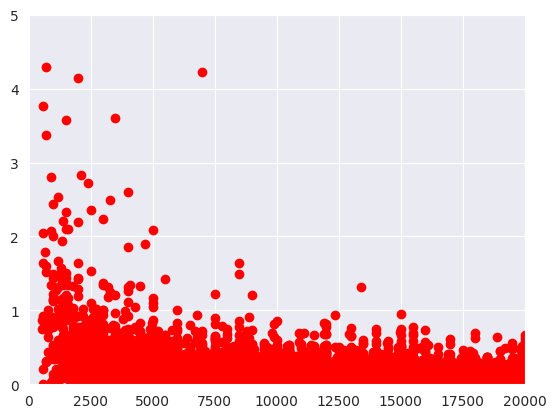

In [521]:
plt.scatter(test_val_linreg.raw_price,test_val_linreg.ape,c='red')
plt.ylim([0,5])
plt.xlim([0,20000])

(0.0, 0.5)

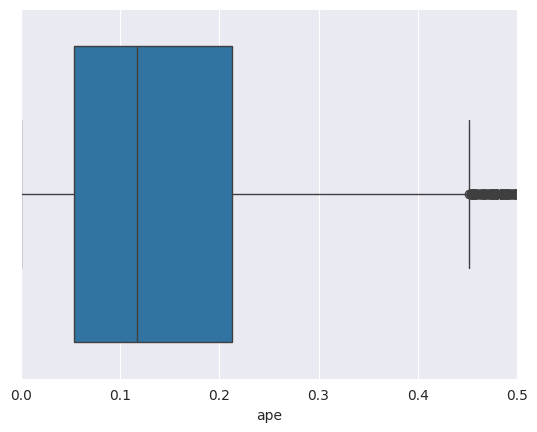

In [530]:
sns.boxplot(test_val_linreg.ape, orient='h')
plt.xlim([0,0.5])

In [532]:
test_val_linreg.ape.describe([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

count    1.060100e+04
mean     1.769194e-01
std      6.443560e-01
min      7.579123e-16
1%       1.848119e-03
5%       1.040729e-02
10%      1.995749e-02
25%      5.315338e-02
50%      1.168552e-01
75%      2.127086e-01
90%      3.497346e-01
95%      4.842180e-01
99%      9.844116e-01
max      6.182568e+01
Name: ape, dtype: float64

(-20000.0, 20000.0)

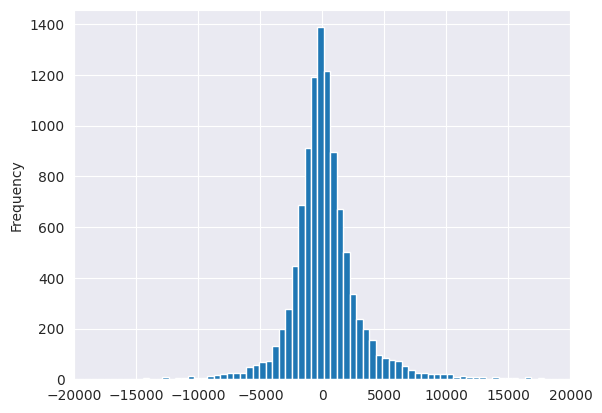

In [537]:
test_val_linreg.residual.plot(kind='hist',bins=500)
plt.xlim([-20000,20000])

In [542]:
from scipy.stats import kstest, anderson

result = anderson(test_val_linreg.residual.to_numpy())  # Compare with normal distribution

print(f"Anderson-Darling Test Statistic: {result.statistic}")
print("Critical values and significance levels:")
for i in range(len(result.critical_values)):
    print(f"Significance Level {result.significance_level[i]}%: {result.critical_values[i]}")



Anderson-Darling Test Statistic: nan
Critical values and significance levels:
Significance Level 15.0%: 0.576
Significance Level 10.0%: 0.656
Significance Level 5.0%: 0.787
Significance Level 2.5%: 0.918
Significance Level 1.0%: 1.092


In [223]:
train_val_linreg = pd.concat([train_val_linreg, fuel_type_encoded_train, gearbox_type_encoded_train], axis=1).drop(columns=['fuel_type', 'gearbox_type'])

<Axes: >

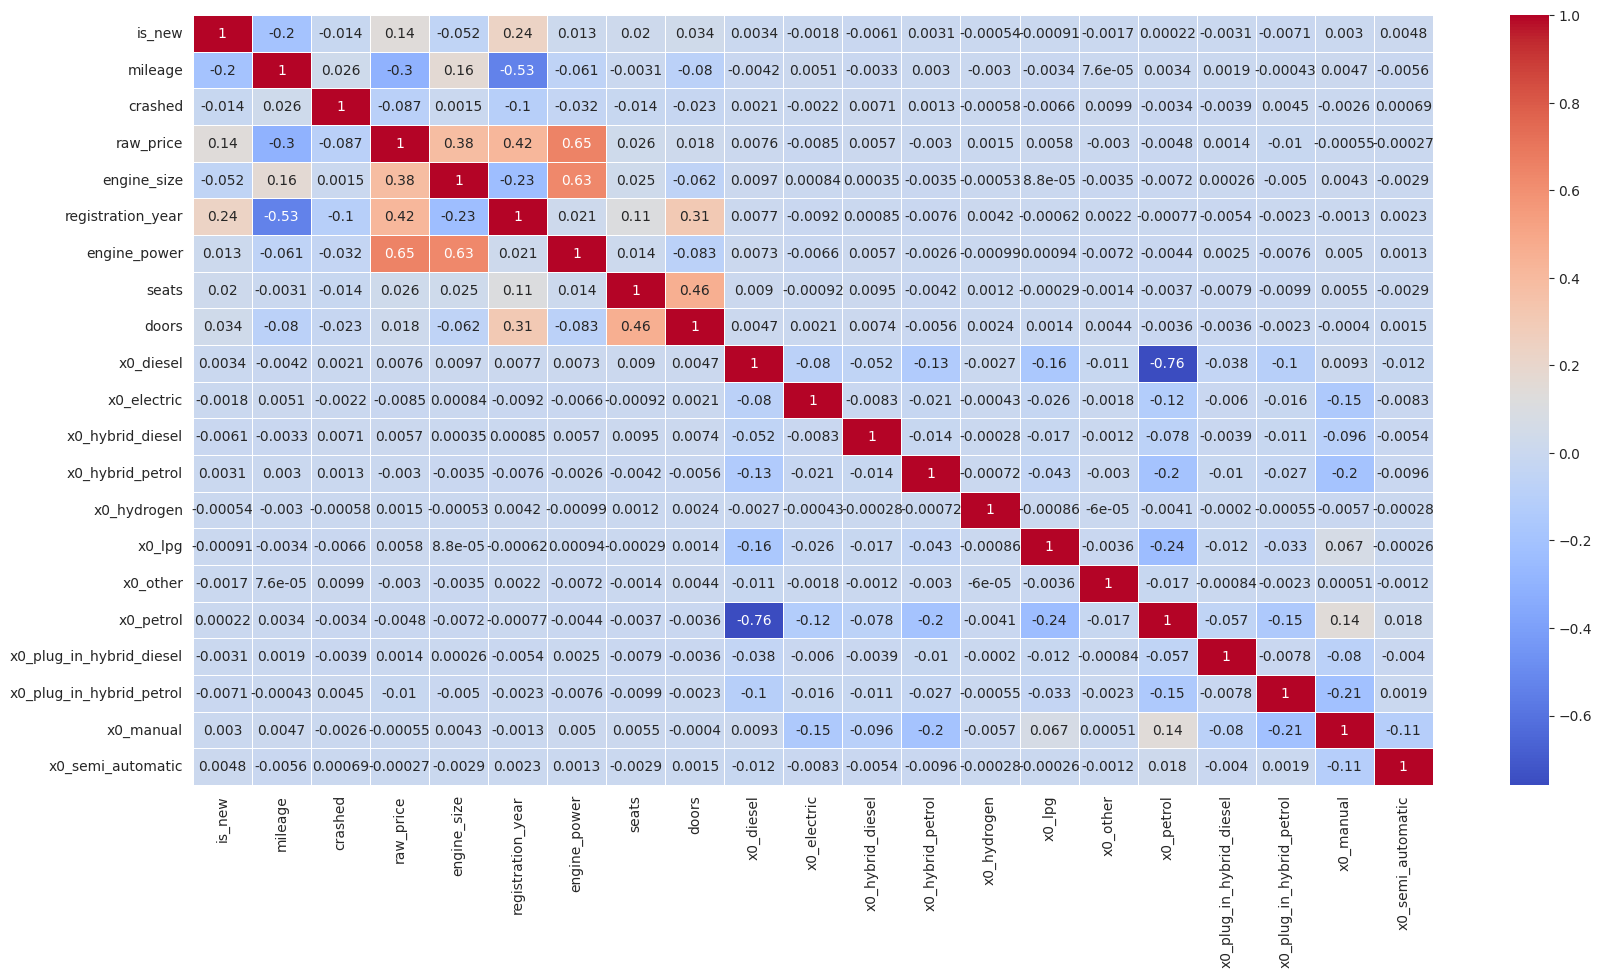

In [228]:
plt.figure(figsize=(20,10))
sns.heatmap(train_val_linreg.select_dtypes(include=[np.number]).corr(), annot=True, linewidths=.5, cmap='coolwarm')

In [700]:
train_val_linreg.engine_size.describe([0.01,0.02,0.05])

count    68969.000000
mean      1592.325857
std        632.729796
min          0.000000
1%         101.000000
2%         700.000000
5%         998.000000
50%       1500.000000
max      10000.000000
Name: engine_size, dtype: float64

In [701]:
train_val_linreg[train_val_linreg.engine_size == 0]

is_new   mileage  crashed  raw_price  engine_size  registration_year  \
70939       0  140000.0        0     9000.0          0.0               2016   
95085       1       1.0        0     9900.0          0.0               2024   
97181       0  220000.0        0     4500.0          0.0               2008   
73725       0    6670.0        0    18000.0          0.0               2018   
84022       0    5000.0        0    28600.0          0.0               2023   
73440       1       0.0        0    46800.0          0.0               2021   
95434       1       1.0        0     9900.0          0.0               2024   
91154       0   39000.0        1    14000.0          0.0               2019   
74470       0   44000.0        0    12900.0          0.0               2018   
80882       0   49042.0        0    14500.0          0.0               2018   
67838       0    3040.0        0     7300.0          0.0               2022   
93065       0   47000.0        0    29990.0          0.0               2017   
86349       0  172000.0        0    18500.0          0.0               2011   
1471        0   28000.0        0    48000.0          0.0               2020   
4616        0    6800.0        0    14900.0          0.0               2022   
77171       0    9784.0        0    22500.0          0.0               2019   
1184        0   35000.0        0    29000.0          0.0               2018   
7805        0  145000.0        0     1500.0          0.0               2002   
81478       0  250000.0        0    10500.0          0.0               2004   
74359       1       0.0        0    56300.0          0.0               2023   
95435       1       1.0        0     9900.0          0.0               2024   

       engine_power fuel_type gearbox_type          brand            model  \
70939           0.0    diesel       manual           ford  transit connect   
95085           1.0  electric    automatic            xev             yoyo   
97181         150.0    petrol       manual           ford            s-max   
73725           0.0  electric    automatic          smart           fortwo   
84022           0.0    petrol       manual           audi               a3   
73440           0.0  electric    automatic     volkswagen             id.4   
95434           1.0  electric    automatic            xev             yoyo   
91154         136.0  electric    automatic     volkswagen             golf   
74470          84.0  electric    automatic          smart           fortwo   
80882           0.0  electric    automatic          smart           fortwo   
67838           1.0  electric    automatic        citroen              ami   
93065         154.0  hydrogen    automatic         toyota            mirai   
86349           1.0    diesel       manual  mercedes-benz         sprinter   
1471          360.0  electric    automatic           audi           e-tron   
4616            0.0  electric    automatic          smart           fortwo   
77171          82.0  electric    automatic          smart           fortwo   
1184          184.0  electric    automatic            bmw               i3   
7805          200.0    petrol       manual  mercedes-benz              200   
81478         190.0       lpg       manual            bmw              320   
74359         136.0  electric    automatic        citroen      spacetourer   
95435           1.0  electric    automatic            xev             yoyo   

       seats exterior_color  doors is_metallic       group_model_year_level  \
70939    2.0          white    4.0       False    ford_transit connect_2016   
95085    2.0           grey    3.0       False                xev_yoyo_2024   
97181    7.0           grey    5.0       False              ford_s-max_2008   
73725    2.0          black    3.0        True            smart_fortwo_2018   
84022    5.0           blue    5.0        True                 audi_a3_2023   
73440    5.0           blue    5.0        True         volkswagen_id.4_2021  